# Task

You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import (confusion_matrix,
                            plot_confusion_matrix,
                            f1_score,
                            fbeta_score,
                            accuracy_score,
                            precision_score,
                            recall_score,
                            roc_auc_score,
                            classification_report
                            )

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Data

In [124]:
df = pd.read_csv('files_for_lab/Customer-Churn.csv')
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,No,Yes,Yes,No,Yes,Yes,One year,103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,Yes,No,No,No,No,No,Month-to-month,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,No,No,No,No,No,No,Month-to-month,74.40,306.6,Yes


# Data cleaning

In [125]:
df.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [126]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### replace empty values

In [127]:
df.replace(' ', np.NaN, inplace=True)

### change column type

In [128]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [129]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

### count null/nans

In [130]:
def get_dataframe_info(df):
    """
    input
       df -> DataFrame
    output
       df_null_counts -> DataFrame Info (sorted)
    """

    df_types = pd.DataFrame(df.dtypes)
    df_nulls = df.count()
    
    df_null_count = pd.concat([df_types, df_nulls], axis=1)
    df_null_count = df_null_count.reset_index()
    
    # Reassign column names
    col_names = ["features", "types", "non_null_counts"]
    df_null_count.columns = col_names
    
    # Add this to sort
    df_null_count = df_null_count.sort_values(by=["non_null_counts"], ascending=True)
    
    return df_null_count

In [131]:
get_dataframe_info(df)

,features,types,non_null_counts
14,TotalCharges,float64,7032
0,gender,object,7043
1,SeniorCitizen,int64,7043
2,Partner,object,7043
3,Dependents,object,7043
4,tenure,int64,7043
5,PhoneService,object,7043
6,OnlineSecurity,object,7043
7,OnlineBackup,object,7043
8,DeviceProtection,object,7043


In [132]:
df['TotalCharges'].value_counts(dropna=False, normalize=False)


NaN        11
20.20      11
19.75       9
20.05       8
19.90       8
           ..
6849.40     1
692.35      1
130.15      1
3211.90     1
6844.50     1
Name: TotalCharges, Length: 6531, dtype: int64

In [133]:
null_values = pd.DataFrame(df.isna().sum(), columns=['null_values'])
null_values['total_values'] = len(df)
null_values['%'] = round(null_values['null_values']/null_values['total_values']*100, 2)
null_values

,null_values,total_values,%
gender,0,7043,0.00
SeniorCitizen,0,7043,0.00
Partner,0,7043,0.00
Dependents,0,7043,0.00
tenure,0,7043,0.00
PhoneService,0,7043,0.00
OnlineSecurity,0,7043,0.00
OnlineBackup,0,7043,0.00
DeviceProtection,0,7043,0.00
TechSupport,0,7043,0.00


### substitute nans

In [134]:
df['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

<Figure size 1600x500 with 0 Axes>

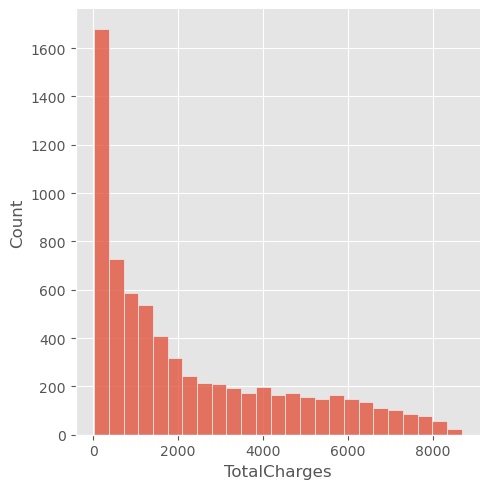

In [135]:
plt.figure(figsize=(16,5))
sns.displot(df['TotalCharges'])

<AxesSubplot:xlabel='TotalCharges'>

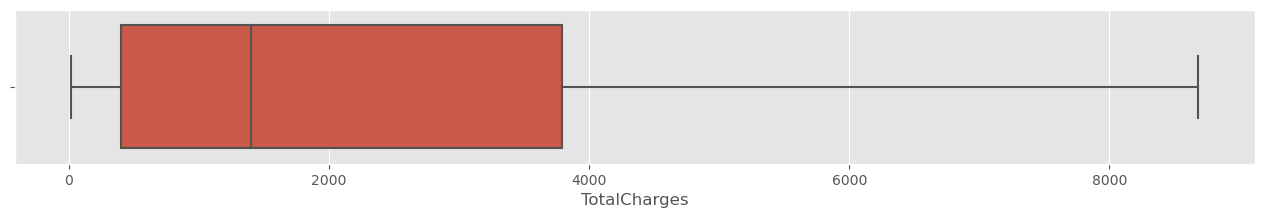

In [136]:
plt.figure(figsize=(16,2))
sns.boxplot(x=df['TotalCharges'])

In [137]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


# Feature engineering

### X-y split

In [138]:
X = df[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
y = df['Churn']

### train-test split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### scaling

In [140]:
scaler = StandardScaler()

In [141]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### checking the data imbalance

In [142]:
y_train.value_counts(normalize=True)

No     0.733582
Yes    0.266418
Name: Churn, dtype: float64

In [143]:
y_test.value_counts(normalize=True)

No     0.738822
Yes    0.261178
Name: Churn, dtype: float64

The imbalance of the data is preserved in the test set.

# Logistic Regression and Decision Tree

In [144]:
def logreg_dectree_report(variable_data, target_data):
    '''Allows to run the Logistic Regression model and the Decision Tree and
    their Classification Reports for a given variable data and target data'''
    # logistic regression model
    logreg = LogisticRegression()
    logreg.fit(variable_data, target_data)
    pred_train_logreg = logreg.predict(variable_data)
    pred_test_logreg = logreg.predict(X_test)
    
    # metrics
    logreg_accuracy = accuracy_score(y_test, pred_test_logreg)
    print(f'LOGISTIC REGRESSION ACCURACY: {round(logreg_accuracy, 3)}')
    
    # confusion matrix
    # logreg_cm = confusion_matrix(y_test, pred_test_logreg)
    # logreg_matrix = plot_confusion_matrix(logreg, X_test, y_test)
    
    # DECISION TREE model
    dectree = DecisionTreeClassifier()
    dectree.fit(variable_data, target_data)
    pred_train_dectree = dectree.predict(variable_data)
    pred_test_dectree = dectree.predict(X_test)
    
    # metrics
    dectree_accuracy = accuracy_score(y_test, pred_test_dectree)
    print(f'DECISION TREE ACCURACY: {round(dectree_accuracy, 3)}')

    # confusion matrix
    # dectree_cm = confusion_matrix(y_test, pred_test_dectree, labels=[y.])
    # dectree_matrix = plot_confusion_matrix(dectree, X_test, y_test)

#    print('REPORT ON TRAIN SET\n\n', classification_report(target_data, pred_train))
#    print('REPORT ON TEST SET\n\n', classification_report(y_test, pred_test))

    return logreg_accuracy, dectree_accuracy
    
#    plt.show()
    


### baseline model

In [145]:
base_logreg_accuracy, base_dectree_accuracy = logreg_dectree_report(X_train, y_train)

LOGISTIC REGRESSION ACCURACY: 0.784
DECISION TREE ACCURACY: 0.713


### oversamplig: smote

In [146]:
sm = SMOTE(k_neighbors=3)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

In [147]:
sm_logreg_accuracy, sm_dectree_accuracy = logreg_dectree_report(X_train_SMOTE, y_train_SMOTE)

LOGISTIC REGRESSION ACCURACY: 0.71
DECISION TREE ACCURACY: 0.698


### downsampling: tomeklinks

In [148]:
tl = TomekLinks(sampling_strategy='all')
X_train_TL, y_train_TL = tl.fit_resample(X_train, y_train)

In [149]:
tl_logreg_accuracy, tl_dectree_accuracy = logreg_dectree_report(X_train_TL, y_train_TL)

LOGISTIC REGRESSION ACCURACY: 0.786
DECISION TREE ACCURACY: 0.714


### combined over and downsampling: SMOTETomek

In [150]:
st = SMOTETomek(tomek=TomekLinks(sampling_strategy='all'), smote=SMOTE(k_neighbors=3))
X_train_ST, y_train_ST = st.fit_resample(X_train, y_train)

In [151]:
st_logreg_accuracy, st_dectree_accuracy = logreg_dectree_report(X_train_ST, y_train_ST)

LOGISTIC REGRESSION ACCURACY: 0.717
DECISION TREE ACCURACY: 0.705


### comparing models accuracy

In [152]:
accuracy = {'LOG REG': [base_logreg_accuracy, sm_logreg_accuracy, tl_logreg_accuracy, st_logreg_accuracy],
          'DEC TREE': [base_dectree_accuracy, sm_dectree_accuracy, tl_dectree_accuracy, st_dectree_accuracy]}

accuracy = pd.DataFrame(metrics, index=['baseline model', 'smote', 'tomeklinks', 'smotetomek'])
accuracy

,LOG REG,DEC TREE
baseline model,0.784244,0.709013
smote,0.712562,0.687722
tomeklinks,0.785664,0.717530
smotetomek,0.716820,0.703336


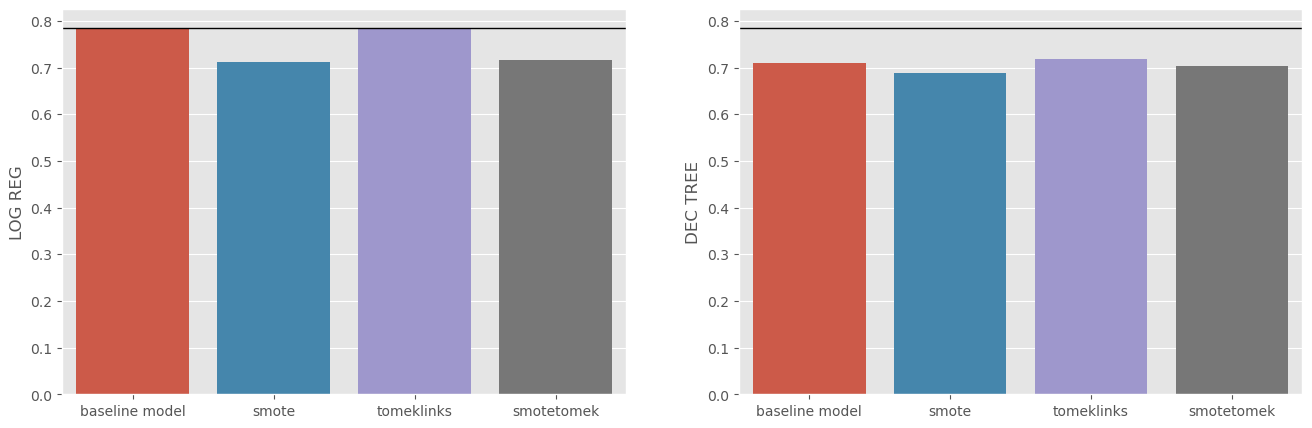

In [153]:
plt.figure(figsize=(16,5))

ax1 = plt.subplot(1, 2, 1,)
sns.barplot(x=accuracy.index, y=accuracy['LOG REG'])
plt.axhline(y=0.785664, linewidth=1, color = 'k')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
sns.barplot(x=accuracy.index, y=accuracy['DEC TREE'])
plt.axhline(y=0.785664, linewidth=1, color = 'k')

As we can see in the dataframe, the best perfoming accuracy is the Logistic Regression algorithm. The baseline model and the TomekLinks score almost the same accuracy.

### other metrics

However, for an imbalanced dataset, accuracy is not a good metric. If we print the classification report on the Logistic Regression models:

In [154]:
logreg_base = LogisticRegression()
logreg_base.fit(X_train, y_train)
pred_test_logreg_base = logreg_base.predict(X_test)


print('BASELINE REPORT ON TRAIN SET\n\n',classification_report(y_test, pred_test_logreg_base))

BASELINE REPORT ON TRAIN SET

               precision    recall  f1-score   support

          No       0.82      0.90      0.86      1041
         Yes       0.62      0.46      0.53       368

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



In [155]:
logreg_sm = LogisticRegression()
logreg_sm.fit(X_train_SMOTE, y_train_SMOTE)
pred_test_logreg_sm = logreg_sm.predict(X_test)


print('SMOTE REPORT ON TRAIN SET\n\n',classification_report(y_test, pred_test_logreg_sm))

SMOTE REPORT ON TRAIN SET

               precision    recall  f1-score   support

          No       0.87      0.71      0.78      1041
         Yes       0.46      0.71      0.56       368

    accuracy                           0.71      1409
   macro avg       0.67      0.71      0.67      1409
weighted avg       0.77      0.71      0.73      1409



In [156]:
logreg_tl = LogisticRegression()
logreg_tl.fit(X_train_TL, y_train_TL)
pred_test_logreg_tl = logreg_tl.predict(X_test)


print('TOMEKLINKS REPORT ON TRAIN SET\n\n',classification_report(y_test, pred_test_logreg_tl))

TOMEKLINKS REPORT ON TRAIN SET

               precision    recall  f1-score   support

          No       0.82      0.90      0.86      1041
         Yes       0.62      0.46      0.53       368

    accuracy                           0.79      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.79      0.77      1409



In [157]:
logreg_st = LogisticRegression()
logreg_st.fit(X_train_ST, y_train_ST)
pred_test_logreg_st = logreg_st.predict(X_test)


print('TOMEKLINKS REPORT ON TRAIN SET\n\n',classification_report(y_test, pred_test_logreg_st))

TOMEKLINKS REPORT ON TRAIN SET

               precision    recall  f1-score   support

          No       0.88      0.72      0.79      1041
         Yes       0.47      0.71      0.57       368

    accuracy                           0.72      1409
   macro avg       0.67      0.72      0.68      1409
weighted avg       0.77      0.72      0.73      1409



As we can expect from the imbalanced dataset, the accuracy metric score is very high, but the recall metric score is pretty low for the minority class. This means that the model failed to “learn” the minority class well, thus failed to correctly predict the minority class label.

The accuracy and precision metrics might decrease, but we can see that the recall metric are higher, it means that the model performs better to correctly predict the minority class label by using SMOTE-Tomek Links to handle the imbalanced data.

In this case, the SMOTE is performing better because the TomekLinks is utterly modifiying the imbalance in the data.

In [177]:
y_train.value_counts() # baseline

No     4133
Yes    1501
Name: Churn, dtype: int64

In [174]:
y_train_SMOTE.value_counts() # smote

No     4133
Yes    4133
Name: Churn, dtype: int64

In [173]:
y_train_TL.value_counts() # tomeklinks

No     3729
Yes    1097
Name: Churn, dtype: int64

In [172]:
y_train_ST.value_counts() # smotetomek

No     3856
Yes    3856
Name: Churn, dtype: int64

### trying stratified k-Fold 

In [34]:
## No Imbalance Handling
# Define model
model=LogisticRegression()
# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.7907
Mean Precision: 0.7382
Mean Recall: 0.6854


In [35]:
## With SMOTE-Tomek Links method
# Define model
model=LogisticRegression()
# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_SMOTETomek, y_train_SMOTETomek = resample.fit_resample(X_train, y_train) 
# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(model, X_train_SMOTETomek, y_train_SMOTETomek, scoring=scoring, cv=cv, n_jobs=-1)
# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.7578
Mean Precision: 0.7588
Mean Recall: 0.7560
